# Defining new acquisition functions
*Joachim van der Herten*

GPflowOpt implements supports some acquisition functions for common scenarios, such as EI and PoF. However, it is straightforward to implement your own strategy. For most strategies, it is sufficient to implement the `Acquisition` interface. In case a more sophisticated model is needed, this can easily be achieved with GPflow.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt 
import copy
import GPflow
import GPflowOpt
import tensorflow as tf

In [2]:
rng = np.random.RandomState(5)
def camelback(X):
    f = (4. - 2.1*X[:,0]**2 + 0.3* X[:,0]**4) * X[:,0]**2 + np.prod(X,axis=1) + 4 * (X[:,1]**2-1) * X[:,1]**2
    return f[:,None] + rng.rand(X.shape[0], 1) * 1

# Setup input domain
domain = GPflowOpt.domain.ContinuousParameter('x1', -3, 3) + \
         GPflowOpt.domain.ContinuousParameter('x2', -2, 2)

As an example on how to implement a custom acquisition function, we illustrate the Augmented EI (Huang et al. 2006), a modification for Expected Improvement for optimization of noisy functions. It is defined as
$$
\alpha_{\text{aEI}}(\mathbf x_{\star}) = \alpha_{\text{EI}}(\mathbf x_{\star}) \left( 1 - \frac{\tau}{\sqrt{\text{Var}\left[ \mathbf f^{\star}\,|\, \mathbf x, \mathbf y, \mathbf x_{\star} \right] + \tau^2}}\right)
$$

This definition can be interpreted as rescaling of the EI score, related to a penalty parameter $\tau$. For $\tau=0$, the rescale term equals 1 and normal EI is recovered. For $\tau > 0$, small prediction variances are punished, decreasing concentration of the sampling. 

To implement this acquisition function, we override the `build_acquisition` method of `ExpectedImprovement` 

In [3]:
class AugmentedEI(GPflowOpt.acquisition.ExpectedImprovement):
    def __init__(self, model, tau):
        super(AugmentedEI, self).__init__(model)
        self.penalty = tau

    def build_acquisition(self, Xcand):
        ei = super(AugmentedEI, self).build_acquisition(Xcand)
        _, pvar = self.models[0].build_predict(Xcand)
        return tf.multiply(ei, 1 - self.penalty / (tf.sqrt(pvar + self.penalty ** 2)))

This small experiment on the six hump camelback illustrates impact of the penalty term.

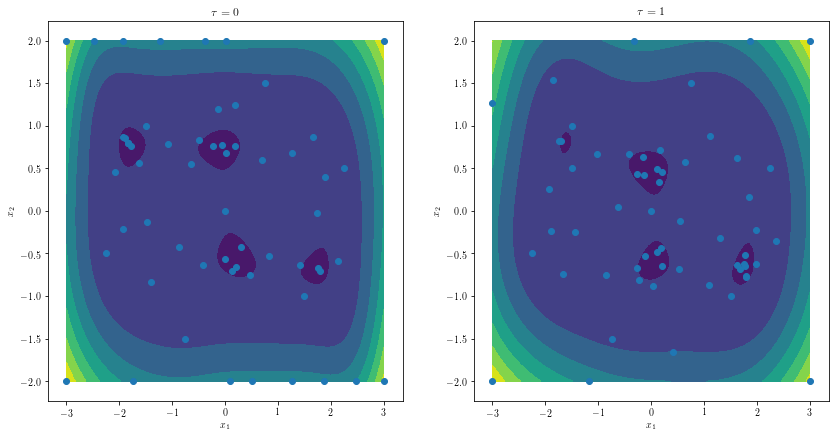

In [4]:
design = GPflowOpt.design.LatinHyperCube(9, domain)
X = design.generate()
Y = camelback(X)
m = GPflow.gpr.GPR(X, Y, GPflow.kernels.Matern52(2, ARD=True, lengthscales=[10,10], variance=10000))
m.likelihood.variance = 1
m.likelihood.variance.fixed = True
aeiv1 = AugmentedEI(m, 0)
m = GPflow.gpr.GPR(X, Y, GPflow.kernels.Matern52(2, ARD=True, lengthscales=[10,10], variance=10000))
m.likelihood.variance = 1
m.likelihood.variance.fixed = True
aeiv2 = AugmentedEI(m, 1)

opt = GPflowOpt.optim.StagedOptimizer([GPflowOpt.optim.MCOptimizer(domain, 200), 
                                       GPflowOpt.optim.SciPyOptimizer(domain)])

bopt1 = GPflowOpt.BayesianOptimizer(domain, aeiv1, optimizer=opt)
bopt1.optimize(camelback, n_iter=50);

bopt2 = GPflowOpt.BayesianOptimizer(domain, aeiv2, optimizer=opt)
bopt2.optimize(camelback, n_iter=50);

f, axes = plt.subplots(1,2, figsize=(14,7))

Xeval = GPflowOpt.design.FactorialDesign(101, domain).generate()
Yeval = camelback(Xeval)
titles = [r'$\tau = 0$', r'$\tau = 1$']
shape = (101, 101)

for ax, t, acq in zip(axes, titles, [aeiv1, aeiv2]):
    pred = acq.models[0].predict_f(Xeval)[0]
    ax.contourf(Xeval[:,0].reshape(shape), Xeval[:,1].reshape(shape), 
                pred.reshape(shape))
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(t)
    ax.scatter(acq.data[0][:,0], acq.data[0][:,1])